# ML regression

-----------------------------------

*This jupyters are the explanation to the Python script stored in the **Cloud Function** folder. The real script is a .py*

----------------------------------

I'm going to:

- Normalise the dataset before applying ML. 
- Use **RFE** (Recursive Feature Elimination) to select the best 15 columns to work with, from the 133 I have.
- Use the fastest regression I can. Speed over performance due to Cloud Function requirements.
- Perform cross validation. Unfortunately I have no enough data for train/validation/test
- Once my model is trained, infer data in the whole dataset, to have a dashboard comparing *real keyword* vs *infered keyword*.

I came from this:

- Part I. Gathering data: **https://github.com/albertovpd/automated_ML_regression/blob/master/1-creating_raw_dataset.ipynb**

- Part II. Processing data: **https://github.com/albertovpd/automated_ML_regression/blob/master/2-processing_raw_dataset.ipynb**

Let's have fun :D

In [11]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

In [2]:
df=pd.read_csv("input/dataset_final_processed.csv")
df.drop(columns='Unnamed: 0', inplace=True)
df.head()

,date,protestas_x,extremismo_x,rebelion_x,refugiados_x,precio_petroleo_x,juicio_x,corrupcion_x,inestabilidad_politica_x,terrorismo_x,...,teletrabajo,tinder,uber,uber eats,videoconferencia,videollamada,vox,yoga,zoom,unemployment
0,2019-02-03,-0.986667,-29.993333,-21.453333,-6.425000,0.00,-111.880000,-92.164000,-7.770000,-82.140000,...,2.0,56.0,27.0,10.0,2.0,2.0,35.0,50.0,5.0,23.0
1,2019-02-10,-16.754286,-2.260000,-17.413333,-15.266667,0.00,-485.394286,-168.828571,-23.500000,-11.586667,...,1.0,51.0,35.0,15.0,3.0,1.0,27.0,44.0,4.0,23.0
2,2019-02-17,-98.830000,-5.644000,-26.305000,0.000000,3.72,-232.251429,-106.468571,-36.120000,-145.260000,...,2.0,50.0,100.0,9.0,3.0,2.0,16.0,41.0,3.0,23.0
3,2019-02-24,-41.448571,-4.226667,-26.570000,1.276000,0.00,-233.122857,-106.342857,-24.146667,-34.084000,...,2.0,52.0,78.0,11.0,3.0,3.0,11.0,49.0,4.0,20.0
4,2019-03-03,-35.362857,0.000000,-28.106667,-20.310000,0.00,-173.451429,-112.497143,-5.160000,-24.512000,...,1.0,50.0,40.0,11.0,3.0,2.0,13.0,48.0,4.0,27.0


In [3]:
print("I have ", len(df.columns), " columns to play with")#columns=list(df.columns)

I have  132  columns to play with


# Shuffle data

I'm not going to shuffle data. It performs a negative impact on my really simple regression. I'll apply a cross validation method to the train dataset

In [4]:
#df_shuffled= df.head(-4).sample(frac=1)
#df_shuffled

In [5]:
# now let's append the last 4 rows removed before
#df_shuffled=df_shuffled.append(df.tail(4), ignore_index=True).reset_index(drop=True)
#df_shuffled

# Normalize

- This dataset is composed by datasets with different scale, so normalize values is needed.

In [6]:
# Transform into standard normal distribution using the z-score definition
X = df.drop(columns=["date","unemployment"]) #returns a numpy array
X = X.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
target=df["unemployment"]

In [7]:
X.head()

,protestas_x,extremismo_x,rebelion_x,refugiados_x,precio_petroleo_x,juicio_x,corrupcion_x,inestabilidad_politica_x,terrorismo_x,vigilancia_x,...,taxi,teletrabajo,tinder,uber,uber eats,videoconferencia,videollamada,vox,yoga,zoom
0,0.079454,-0.227000,-0.048510,0.004997,0.055642,0.126841,-0.005161,0.042840,-0.408330,-0.129363,...,-0.059938,-0.125725,-0.244889,-0.186170,-0.394903,-0.090157,-0.069955,0.191150,0.040725,-0.098157
1,0.018951,0.038086,-0.013077,-0.073158,0.055642,-0.642666,-0.290909,-0.007129,0.077374,-0.537050,...,0.025428,-0.135826,-0.342929,-0.083606,-0.339958,-0.080056,-0.080056,0.106043,-0.053025,-0.108467
2,-0.295988,0.005740,-0.091062,0.061790,0.324817,-0.121146,-0.058478,-0.047218,-0.842861,-0.335707,...,0.647379,-0.125725,-0.362537,0.749727,-0.405892,-0.080056,-0.069955,-0.010978,-0.099900,-0.118776
3,-0.075805,0.019288,-0.093386,0.073069,0.055642,-0.122941,-0.058010,-0.009183,-0.077503,0.065125,...,0.464453,-0.125725,-0.323321,0.467676,-0.383914,-0.080056,-0.059854,-0.064169,0.025100,-0.108467
4,-0.052453,0.059688,-0.106864,-0.117738,0.055642,-0.000007,-0.080948,0.051131,-0.011607,-0.014582,...,0.244940,-0.135826,-0.362537,-0.019504,-0.383914,-0.080056,-0.069955,-0.042893,0.009475,-0.108467


In [8]:
target.head()

0    23.0
1    23.0
2    23.0
3    20.0
4    27.0
Name: unemployment, dtype: float64

Google Trends works oddly. You request a range of time, and it processes the info before delivering. Score 100 means it was the maximum peak in all times, and all the column is normalized by that peak, but we can't see the exactly number of searches.

# Splitting and k-folds validation.

There are not a lot of data, so splitting and shuffling my dataset ends with terrible metrics for a fast linear regression. 


In [9]:
# all but last 4 rows
X_train=X.iloc[:-4]
target_train=target.iloc[:-4]

# last 4 rows, which are the ones I have no data and I want to infer
X_test=X.iloc[-4:]
target_test=target.iloc[-4:]

# Model selection

Here is where I run different models and perform tunning of hyperparameter for better fit, and:

- Divide between train/validation/test
- Train the models with train
- Validate metrics with validation
- Perform inferences with test
- Select the best model of all and train it with the whole dataset

**That's not going to happen... Yet**. This is a leisure project and my main concern is having something that works within a Cloud Function, in my GCP pipelines. It means my baby needs to run with 4GB of RAM as maximum and 60 seconds of timeout, so I will start with the simplest and fastest model I can.

When I get that, myself from the future will refactorize code and improve metrics. 

So, right now, the selected model will be a Lasso regression after a recursive feature elimination. 

- The model will select the 15 best columns to work with.
- After it, Lasso will remove from the equation the less relevants.

It is like a double filter of simplicity that I hope it works

# Selecting best features using RFE

(Recursive Feature Elimination)

In [13]:
# alpha=1 is like a regular regression. for getter performance use elastic net instead (l1&l2 mix).
regression = Lasso(alpha=0.1)
#regression = LinearRegression() # oher model

# neg mean squared error. it always is negative but what you get is the positive representation
rfecv = RFECV(estimator=regression, step=1, min_features_to_select=15, cv=5,scoring='neg_mean_squared_error')
rfecv.fit(X_train, target_train)

RFECV(cv=5,
      estimator=Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
                      normalize=False, positive=False, precompute=False,
                      random_state=None, selection='cyclic', tol=0.0001,
                      warm_start=False),
      min_features_to_select=15, n_jobs=None, scoring='neg_mean_squared_error',
      step=1, verbose=0)

In [14]:
# Inferences 4 weeks ahead
rfecv.predict(X_test) 

array([30.03721134, 33.56642105, 32.38890311, 33.2460862 ])

In [15]:
# it's unfortunate not having X and target validation, but k-folds cross validation was implemented for that precisely 
rfecv.score(X_train, target_train)

0.8706019108312256

# CSV with infered keyword vs real keyword

- Last 4 rows are the truly interesting ones... Foreseeing with 4 weeks in advance.

In [17]:
result=pd.DataFrame()
result["date"]=df["date"]
result["real_searches"]=df["unemployment"]
result["infered_results"]=pd.DataFrame(rfecv.predict(X))

result["infered_results"]=result["infered_results"].apply(lambda x: 0 if x<0 else round(x,2))
result.head()

,date,real_searches,infered_results
0,2019-02-03,23.0,21.20
1,2019-02-10,23.0,22.13
2,2019-02-17,23.0,24.72
3,2019-02-24,20.0,22.53
4,2019-03-03,27.0,20.11


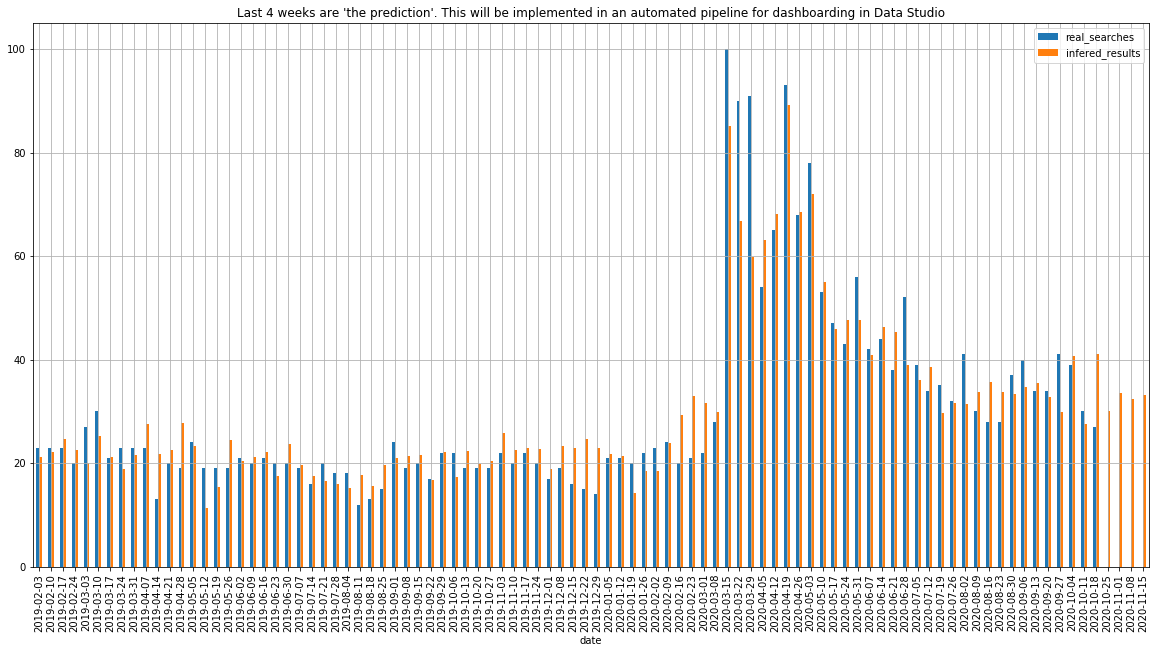

In [18]:
# visualization
result.plot(x="date",
            y=["real_searches","infered_results"],
            figsize=(20,10), 
            kind="bar",
            title="Last 4 weeks are 'the prediction'. This will be implemented in an automated pipeline for dashboarding in Data Studio",
            grid=True)

## CSV to append weekly the score

In [23]:
score = pd.DataFrame({"date": [max(df["date"])], 'score': [round(rfecv.score(X_train, target_train),4)]})
score.to_csv("input/weekly_score.csv")
score

,date,score
0,2020-11-15,0.8706


## CSV to overwrite weekly ranking of features by importance

In [22]:
# Ranking of how important are the following keywords to infer in Google searches in Spain
# the keyword "unemployment"

features=pd.DataFrame()
features["features"]=X.columns
features["top_important"]=rfecv.ranking_
features.sort_values(by=["top_important"], inplace=True)
features.reset_index(drop=True, inplace=True)
features.to_csv("input/ranking_of_features.csv")
features.head(50)
# with a linear regression the number of important features was reduced. It also had better performance.

,features,top_important
0,residencia ancianos,1
1,banco alimentos,1
2,ejercito_y,1
3,stock_market,1
4,formacion,1
5,erc,1
6,divorcio,1
7,disney,1
8,deshaucio,1
9,finanzas_y_bancos,1
